In [4]:
import math
import numpy as np
import pandas as pd
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

# Create one random seed number for reproducible results
seedNum = 888

### Reading data

In [5]:
#[kannan: directly reading the data, later change the pipeline to preprocessed, feature engineered data]
inputFile = '../data/output/OnlineNewsPopularity_featureEngg.csv' 
df = read_csv(inputFile)
df.columns = df.columns.str.replace(' ','')
df.head()

,keywords_pca_3,NER_DATE,num_imgs,n_tokens_title,data_channel_is_entertainment,data_channel_is_socmed,NER_list_pca_2,keywords_pca_4,keywords_pca_6,average_token_length,...,num_videos,NER_ORDINAL,is__Thursday,keywords_pca_9,is_Weekend,is__Wednesday,NER_LANGUAGE,Id,shares,url
0,0.824494,16,1,10,0,0,2.477704,0.587261,0.445485,4.873563,...,1,0,0,-0.052964,0,0,0,1,1100,http://mashable.com/2014/09/01/americans-held-...
1,1.642639,3,50,7,0,0,-1.085392,-0.390698,-0.310026,4.554439,...,0,0,0,0.278347,0,0,0,2,1100,http://mashable.com/2014/09/01/apple-visa-mast...
2,-0.439429,11,1,7,0,0,5.071529,-0.441275,0.401293,5.003976,...,0,1,0,0.520324,0,0,0,3,1000,http://mashable.com/2014/09/01/aussie-football...
3,0.145078,2,1,10,0,0,-3.481954,0.423683,0.819319,4.998099,...,0,2,0,0.097977,0,0,0,4,822,http://mashable.com/2014/09/01/australia-gover...
4,0.639700,6,1,13,0,0,-10.271313,-0.420657,-0.600039,5.046414,...,0,1,0,-0.662537,0,0,0,5,841,http://mashable.com/2014/09/01/australia-jane-...


In [6]:
# Dropping useless attributes
df.drop('url', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

In [7]:
# variables for total columns, total input attributes, target column index and renaming target variable
totCol = len(df.columns)
totAttr = totCol-1
targetCol = totCol #last column
df.rename(columns={'shares': 'targetVar'}, inplace=True)

In [8]:
#70:30 train test split
if targetCol == totCol :
    x_df = df.iloc[:,0:totAttr]
    y_df = df.iloc[:,totAttr]
else :
    x_df = df.iloc[:,1:totCol]
    y_df = df.iloc[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=validation_size, random_state=seedNum)
print("x_df.shape: {} y_df.shape: {}".format(x_df.shape, y_df.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_df.shape: (7795, 39) y_df.shape: (7795,)
x_train.shape: (5456, 39) y_train.shape: (5456,)
x_test.shape: (2339, 39) y_test.shape: (2339,)


In [9]:
# visualization configs
dispCol = 3
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to 16 and height to 12 (4:3 aspect ratio)
fig_size = pyplot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
pyplot.rcParams["figure.figsize"] = fig_size

In [10]:
#kannan: This is decided from feature engineering / feature selection
lowAttributes=[]

In [11]:
# Removing the unselected attributes from the training and validation dataframes
#xy_train <- xy_train[, !(names(xy_train) %in% lowAttributes)]
#xy_test <- xy_test[, !(names(xy_test) %in% lowAttributes)]
xy_newdf = df.drop(lowAttributes, axis=1)

totCol = len(xy_newdf.columns)
totAttr = totCol-1
targetCol = totCol
array = xy_newdf.values

if targetCol == totCol :
    x_newdf = array[:,0:totAttr]
    y_newdf = array[:,totAttr]
else :
    x_newdf = array[:,1:totCol]
    y_newdf = array[:,0]

validation_size = 0.30
x_train, x_test, y_train, y_test = train_test_split(x_newdf, y_newdf, test_size=validation_size, random_state=seedNum)
print("x_newdf.shape: {} y_newdf.shape: {}".format(x_newdf.shape, y_newdf.shape))
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_newdf.shape: (7795, 39) y_newdf.shape: (7795,)
x_train.shape: (5456, 39) y_train.shape: (5456,)
x_test.shape: (2339, 39) y_test.shape: (2339,)


## Traditional ML Models Evaluation

In [12]:
# Comparing various types of regression # K-fold cross validation
num_folds = 10
scoring = 'neg_mean_squared_error'
#Other scoring options: https://scikit-learn.org/stable/modules/model_evaluation.html
models = []

# LINEAR ALGORITHMS
# -----------------
# Linear Regression
models.append(('LR', LinearRegression()))
# Ridge Regression
models.append(('RR', Ridge(random_state=seedNum)))
# Lasso Regression
models.append(('LASSO', Lasso(random_state=seedNum)))
# Elastic Net
models.append(('EN', ElasticNet(random_state=seedNum)))

# NON-LINEAR ALGORITHMS
# ---------------------
# Classification and Regression Trees
models.append(('CART', DecisionTreeRegressor(random_state=seedNum)))
# K Nearest Neighbor
models.append(('KNN', KNeighborsRegressor()))
# Suppor Vector machine
models.append(('SVM', SVR()))

# ENSEMBLE ALGORITHMS
# -------------------
# Extra Trees
models.append(('ETree', ExtraTreesRegressor(random_state=seedNum)))
# Random Forest
models.append(('RF', RandomForestRegressor(random_state=seedNum)))
# Stochastic Gradient Boosting
models.append(('GBM', GradientBoostingRegressor(random_state=seedNum)))
# Adaptive Boosting
models.append(('ABM', AdaBoostRegressor(random_state=seedNum)))

results = []
names = []
metrics1= [] #RMSE_Training
metrics2= [] #RMSE_Testing

## Training

In [13]:
for name, model in models:
    startTimeModule = datetime.now()
    kfold = KFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    rmse=math.sqrt(abs(cv_results.mean()))
    metrics1.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))
    print ('Model training time:',(datetime.now() - startTimeModule))


LR: rmse:7006.861252
Model training time: 0:00:00.101819

RR: rmse:7006.403958
Model training time: 0:00:00.055331

LASSO: rmse:7006.675914
Model training time: 0:00:00.414648

EN: rmse:7033.232583
Model training time: 0:00:00.078414

CART: rmse:10662.840125
Model training time: 0:00:01.536932

KNN: rmse:7685.369061
Model training time: 0:00:00.370190

SVM: rmse:7260.766174
Model training time: 0:00:16.548455

ETree: rmse:7688.899755
Model training time: 0:00:02.907223

RF: rmse:7793.965237
Model training time: 0:00:08.617347

GBM: rmse:7206.455866
Model training time: 0:00:07.069847

ABM: rmse:17282.428829
Model training time: 0:00:06.597761


## Testing

In [14]:
for name, model in models:
    model.fit(x_train, y_train)
    predictions=model.predict(x_test)
    rmse=math.sqrt(mean_squared_error(y_test, predictions))
    metrics2.append(rmse)
    print("\n%s: rmse:%f" % (name, rmse))


LR: rmse:10278.971553

RR: rmse:10279.511847

LASSO: rmse:10279.707052

EN: rmse:10311.165656

CART: rmse:13349.080144

KNN: rmse:10703.914310

SVM: rmse:10525.679990

ETree: rmse:10712.464789

RF: rmse:10829.637982

GBM: rmse:10473.724544

ABM: rmse:18506.868904


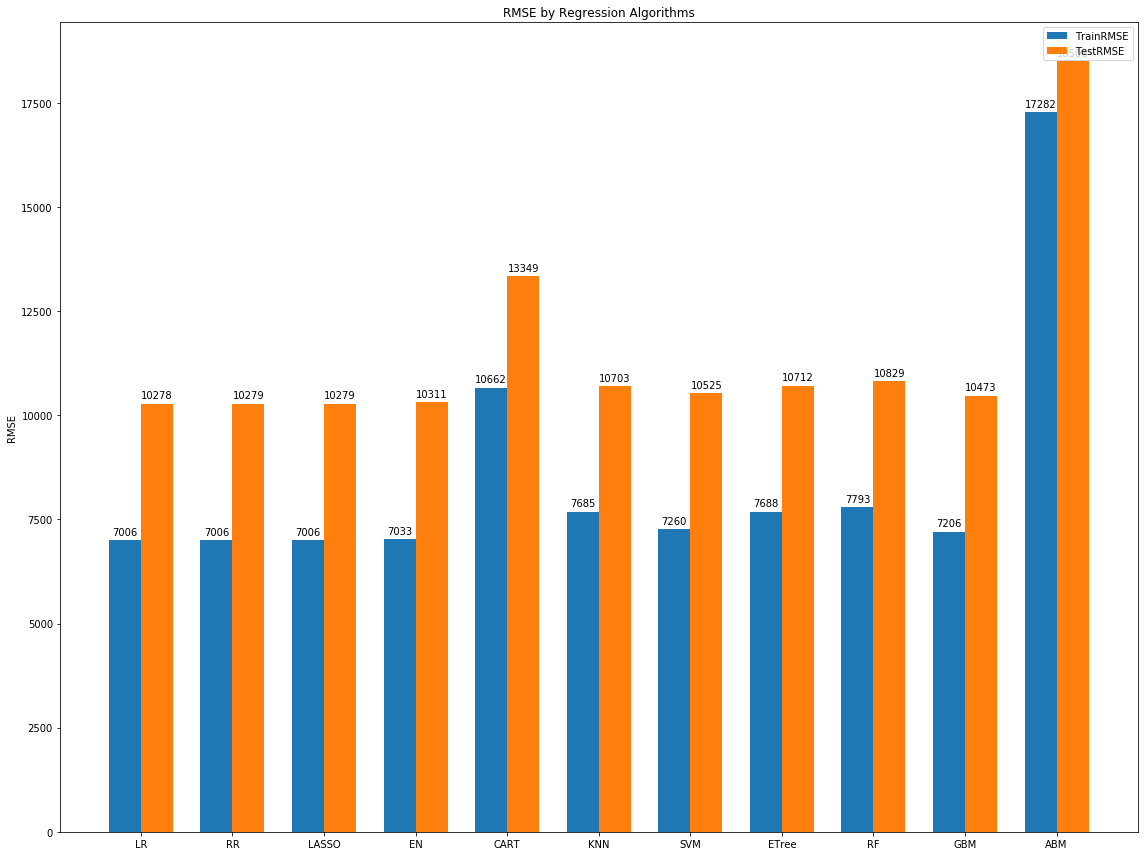

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = names

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

metrics1=[math.floor(item) for item in metrics1]
metrics2=[math.floor(item) for item in metrics2]

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics1, width, label='TrainRMSE')
rects2 = ax.bar(x + width/2, metrics2, width, label='TestRMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE')
ax.set_title('RMSE by Regression Algorithms')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()